In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))

False
0


In [3]:
# data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

The dataloader is compoosed of 12 batches, each of them of size 15 making a total of: 180, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

12


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\Alex\.conda\envs\tfm\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.) tensor(1.)


In [7]:
for i, (_data, _) in enumerate(dataloader):
    if(i==9):
        break
    print(i)

0
1
2
3
4
5
6
7
8


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

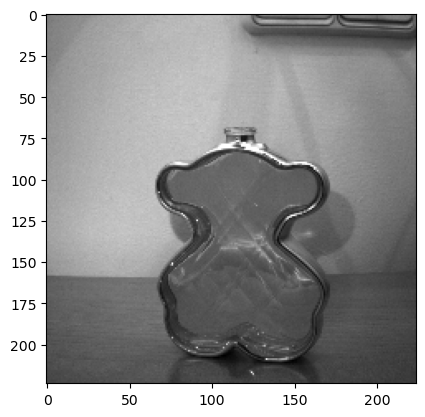

In [8]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # Dimension rseult: -> 15, 110, 44, 44. Batch size, channel output, output image shape
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        self.encoder_tanh = nn.Tanh()
        

        self.decoder_tanh = nn.Tanh()
        self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 1, 224, 224
            nn.Sigmoid()
        )

        

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            encoded = self.encoder(x)
            print("encoded shape after the entire encoder sequence net is:", encoded.shape)
            encoded = encoded.view(encoded.size(0), -1)
            print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            linearCombined = self.fc(encoded)
            print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            tanhed = self.encoder_tanh(linearCombined)
            print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450

            print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            print("decoded shape is:", decoded.shape)
            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            encoded = self.encoder(x)
            # print("encoded shape after the entire encoder sequence net is:", encoded.shape)
            encoded = encoded.view(encoded.size(0), -1)
            # print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            linearCombined = self.fc(encoded)
            # print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            tanhed = self.encoder_tanh(linearCombined)
            # print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450

            # print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            # print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            # print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            # print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            # print("decoded shape is:", decoded.shape)
            # print("Finish the FORWARD function")
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cpu


In [11]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [12]:
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (fc): Linear(in_features=450, out_features=450, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=450, out_features=450, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [13]:
# torch.cuda.empty_cache()

In [14]:
# # Point to training loop video
# num_epochs = 300
# outputs = []
# for epoch in range(num_epochs):
#     for (img, _) in dataloader:     # This iterates over the batches of images.
#         img = img.to(device)
#         # Forward pass
#         recon = model(img)          # The entire batch of images is passed to the model
#         loss = criterion(recon, img)

#         # Backward and optimize
#         optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
#         loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
#         optimizer.step()            # can be called once the gradients are computed 

#     print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
#     outputs.append((epoch, img, recon))

Saving and loading a model

In [15]:
filepath = "../../models/pytorchModels/PytorchCUDAencoderMod"


In [16]:
# torch.save(model.state_dict(), filepath)

In [16]:
# For loading the model 
# model.load_state_dict(torch.load(filepath)) # For home laptop
model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu'))) # For work laptop
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (fc): Linear(in_features=450, out_features=450, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=450, out_features=450, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [17]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

## Analyzing each layer of the Autoencoder model

In [18]:
i = 0
j = 0
for (x, _) in dataloader:                                       # Iterate over the batches of the training set
    if j == 0:
        x = x.to(device)                                        # Place the batch of images to the GPU or CPU depending on the resources
        batch_imgs = x
        code = model(x,True)    
        j = j+1  

print("this is the shape of imgs_croped : ", batch_imgs.shape)
print("this is the shape of code : ", code.shape)

c:\Users\Alex\.conda\envs\tfm\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The FORWARD function is starting
The ENCODER part is executing
encoded shape after the entire encoder sequence net is: torch.Size([15, 450, 1, 1])
encoded shape after the encoded.view is:  torch.Size([15, 450])
linearCombined shape after the self.fc is:  torch.Size([15, 450])
tanhed shape after the self.encoder_tanh is:  torch.Size([15, 450])
The DECODER part is executing
dec_tanhed shape after the self.decoder_tanh is:  torch.Size([15, 450])
dec_linearCombined shape after the self.decoder_fc is:  torch.Size([15, 450])
dec_linearCombined shape after the dec_linearCombined.view is:  torch.Size([15, 450, 1, 1])
decoded shape is: torch.Size([15, 3, 224, 224])
Finish the FORWARD function
this is the shape of imgs_croped :  torch.Size([15, 3, 224, 224])
this is the shape of code :  torch.Size([15, 3, 224, 224])


Original Images


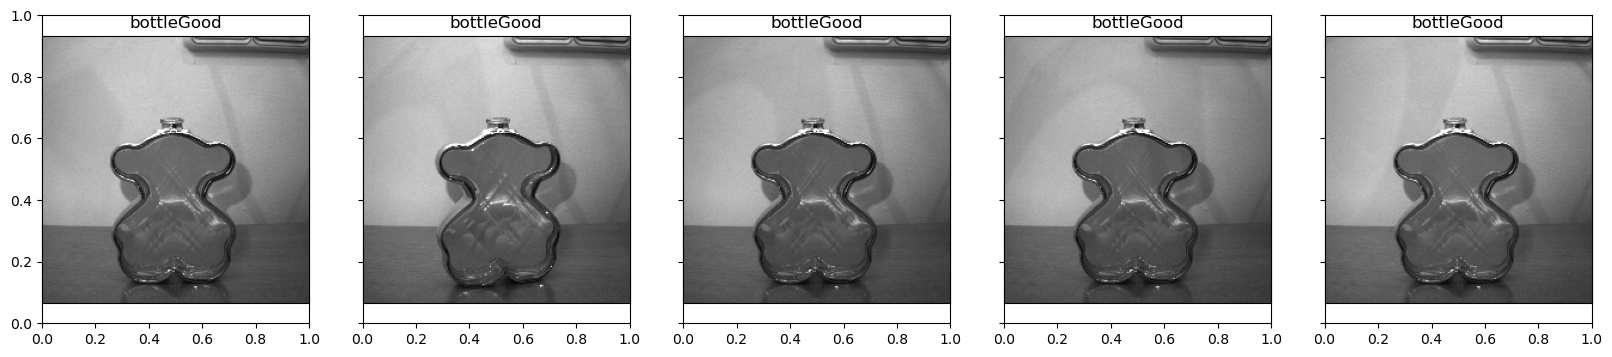

Reconstructed Images


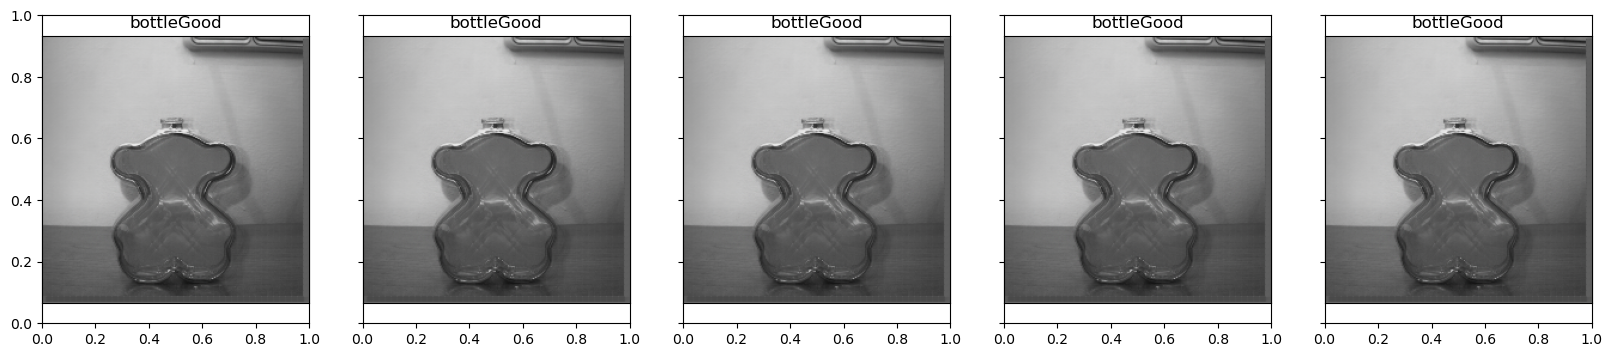

In [19]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)
# images, labels = images.cuda(), labels.cuda() # add this line for displaying the image. For home laptop
images, labels = images, labels # add this line for displaying the image
#Sample outputs
output = model(images)

images = images.cpu().numpy()

# output = output.view(32, 3, 224, 224)
output = output.view(15, 3, 224, 224)       # Because the batch size was changed to 15
output = output.cpu().detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
# plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the training dataset. Additionally, consider the mean reconstruction error, rather than the direct sum of these.

In [20]:
X = dataset[0]
image_in_tensor = X[0]
result_lst = []
n_features = len(image_in_tensor[0])  
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()   # If using the GPU
    image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 3.558508736746652), (1, 1.6471005394345237), (2, 2.0793773106166293), (3, 0.5753125690278553), (4, 0.33094626381283715), (5, 0.5743468148367745), (6, 0.420597167242141), (7, 0.4411488487606957), (8, 0.38771915435791016), (9, 0.3766035806565058), (10, 0.3216210774012974), (11, 0.29601698830014184), (12, 1.6701044355119978), (13, 1.5371160961332775), (14, 0.9986208961123512), (15, 0.5670762743268695), (16, 0.34177271525065106), (17, 0.6577842803228469), (18, 0.46940503801618305), (19, 2.2413442702520463), (20, 2.8898518880208335), (21, 2.824005853562128), (22, 1.8748121715727306), (23, 1.2646273658389138), (24, 0.3997586114065988), (25, 0.741308711823963), (26, 1.7042308989025297), (27, 1.6744303022112166), (28, 2.231469290597098), (29, 2.0453024364653087), (30, 0.6533128647577195), (31, 0.3832817077636719), (32, 1.6440010070800781), (33, 1.7138155982607888), (34, 1.4709804171607608), (35, 1.167837415422712), (36, 1.5483258565266926), (37, 2.1114614577520463), (38, 2.442934853690011

In [21]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 3.558508736746652), (20, 2.8898518880208335), (21, 2.824005853562128), (39, 2.8052580697195872), (155, 2.4624481201171875), (38, 2.4429348536900113), (19, 2.2413442702520463), (28, 2.231469290597098), (37, 2.1114614577520463), (2, 2.0793773106166293), (29, 2.0453024364653087), (120, 1.8852104913620722), (22, 1.8748121715727306), (146, 1.8031774248395647), (168, 1.7413893200102306), (176, 1.7199192955380393), (33, 1.7138155982607888), (26, 1.7042308989025297), (177, 1.678239004952567), (27, 1.6744303022112166), (12, 1.6701044355119978), (102, 1.6641222635904949), (1, 1.6471005394345237), (32, 1.6440010070800781), (137, 1.6322288513183594), (175, 1.6095479329427083), (178, 1.5575172787620908), (36, 1.5483258565266926), (165, 1.5444070725213914), (13, 1.5371160961332775), (34, 1.4709804171607608), (163, 1.468628202165876), (164, 1.4068636213030135), (144, 1.4017386663527716), (169, 1.4012574695405506), (142, 1.3990094321114677), (161, 1.39864258539109), (167, 1.3975519452776228), (14

Gaphically the distribution of the reconstruction error values is shown below:

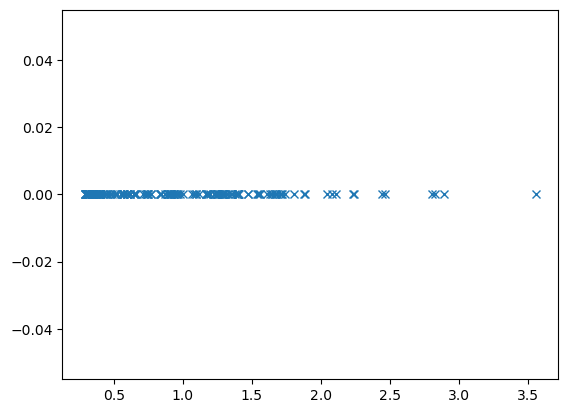

In [22]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [23]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.960174690824013
The standard deviation of the errors list is:  0.6160438844566826
The min value of the errors list is:  0.288821470169794
The max value of the errors list is:  3.558508736746652


## Checking the MSE reconstruction error of the anomaly images

We first load the anomaly images dataset

In [24]:
# data_anomalies = '../../../Images/BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
data_anomalies = '../../../../BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset_anomalies = datasets.ImageFolder(data_anomalies, transform=transform_characteristics)
dataloader_anomalies = torch.utils.data.DataLoader(dataset_anomalies, batch_size=32, shuffle=True)

In [25]:
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]
# image_in_tensor = image_in_tensor.cuda()            # If using the GPU
image_in_tensor = image_in_tensor            # If NO GPU
n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()            # If using the GPU
    image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.3928667704264323), (1, 1.2357303982689267), (2, 1.4225700015113467), (3, 3.564991905575707), (4, 0.6772374652680897), (5, 0.7750713711693173)]


In [26]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(3, 3.564991905575707), (2, 1.4225700015113467), (1, 1.2357303982689267), (5, 0.7750713711693173), (4, 0.6772374652680897), (0, 0.3928667704264323)]


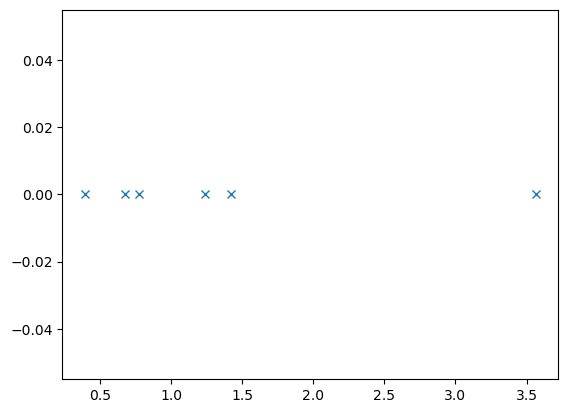

In [27]:
errors_list_anomalies = []
for i in range(len(result_lst)):
    errors_list_anomalies.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [28]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  1.3447446520366366
The standard deviation of the errors list is:  1.0506826155896383
The min value of the errors list is:  0.3928667704264323
The max value of the errors list is:  3.564991905575707


## Comparing the reconstruction error of anomaly and normal images

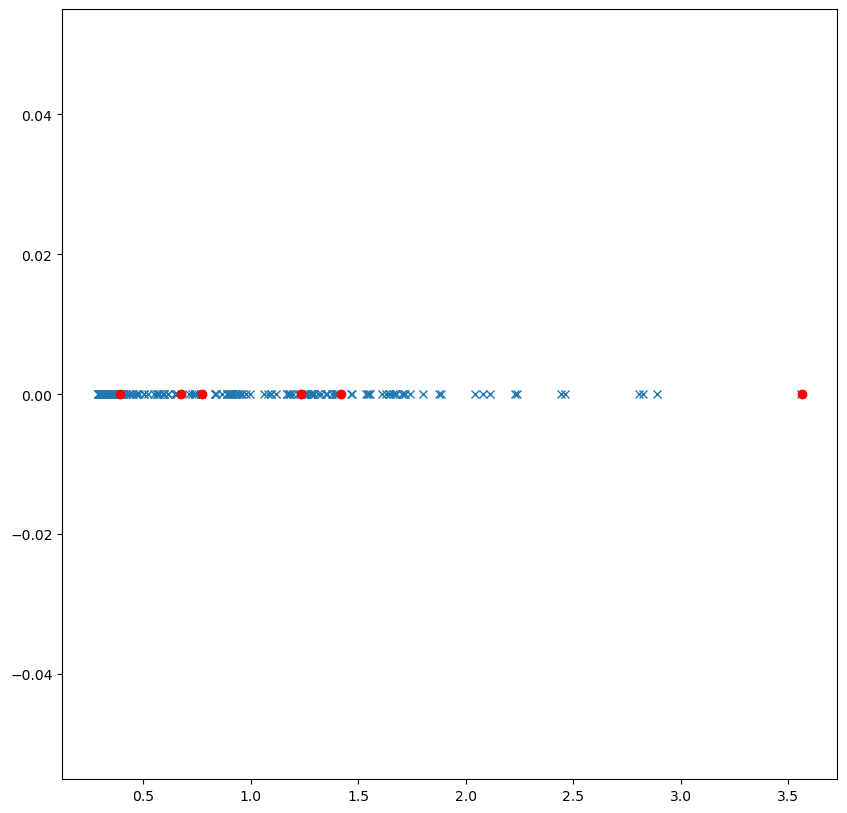

In [29]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

Above see that the reconstruction error between normal and anomaly images are NOT clearly divided in the plot. This could be a problem for the overall detection.

# Coding a function to check if an image contains anomalies

We know that for the non-anomaly images, the mean and std devation is:

In [30]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.960174690824013
The standard deviation of the errors list is:  0.6160438844566826
The min value of the errors list is:  0.288821470169794
The max value of the errors list is:  3.558508736746652


And for the anomaly image, the std deviation and mean values are:

In [31]:
a_avg_rcn_error = np.mean(np.array(errors_list_anomalies))  
a_stdev_rcn_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE TRAINING ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_avg_rcn_error)
print("The standard deviation of the errors list is: ", a_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING ANOMALY IMAGES

The average of the errors list is:  1.3447446520366366
The standard deviation of the errors list is:  1.0506826155896383
The min value of the errors list is:  0.3928667704264323
The max value of the errors list is:  3.564991905575707


According to this, we will work with the following:

- The error value is 0.960174. This is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as an anomaly image.
- The error value is 0.960174 +/- 0.616043. Then the probability of being detected as an anomaly bottle is 50%. And, as typically, we decide that a value higher than 50% is considered as an anomaly image, then every value higher or lower than this quantity will be considered as an anomaly image.

In [32]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [33]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [34]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

49.999999999999986


In [37]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

Moreover, we decide whether an image is anomaly or not, based on its reconstruction error.

In [38]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 9.34419443e-01 9.08378971e-01 8.80722764e-01 7.50787260e-01
 7.42347667e-01 6.84206722e-01 6.34057613e-01 6.16631886e-01
 6.11677939e-01 6.03898705e-01 5.82802891e-01 5.79711632e-01
 5.76200627e-01 5.71345314e-01 5.57529963e-01 5.55014288e-01
 5.45459648e-01 5.27051123e-01 4.84821458e-01 4.77361419e-01
 4.74180814e-01 4.68263236e-01 4.14585502e-01 4.12676373e-01
 3.62546356e-01 3.58386786e-01 3.57996232e-01 3.56171656e-01
 3.55873912e-01 3.54988715e-01 3.52357820e-01 3.51277642e-01
 3.38859454e-01 3.19429356e-01 3.18914736e-01 3.16862300e-01
 2.99744859e-01 2.87400463e-01 2.73264147e-01 2.69923503e-01
 2.69811674e-01 2.69116962e-01 2.61641074e-01 2.61430464e-01
 2.59775512e-01 2.49690549e-01 2.47103074e-01 2.40602760e-01


Let's now check the reconstruction error of the anomaly images.

In [39]:
print("Considering the anomaly dataset. The number of images to be cheked is: ", len(errors_list_anomalies))
preds_probs = np.array(map_error2prob_list(errors_list_anomalies))
preds_probs = preds_probs/100
print("The prediction probabilities list for the anomaly images is: ")
print(preds_probs)

Considering the anomaly dataset. The number of images to be cheked is:  6
The prediction probabilities list for the anomaly images is: 
[1.         0.37529413 0.22364941 0.1502355  0.22964048 0.46044441]


See that for the classification of the anomaly images we have:
- One samples that was correctly identified as anomaly images.
- Five samples that were classified as non-anomaly. These are false negatives.


# Evaluating the performance of the model

So far, it has been used two dataset for doing the above tests: The full non-anomalies dataset and a full anomalies dataset. We will create a third dataset with a mix of these two types of images.

In [40]:
# test_dir = '../../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
classes = ('non-anomaly','anomaly')

In [41]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred


In [42]:
y_true = []
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    # image_in_tensor = image_in_tensor.cuda()   # If using the GPU
    image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print(result_lst)
print(y_true)

[1.6261002676827567, 1.4932659694126673, 1.370353789556594, 1.3755158923921131, 1.342782701764788, 1.3126402355375744, 1.4100286392938524, 1.4661696297781808, 1.7527961730957031, 1.5624157133556547, 1.7217132931663877, 1.6457388741629464, 1.747560046968006, 1.565327417282831, 1.4295565287272136, 1.6891846429734003, 1.3889837719145275, 1.257962908063616, 1.409334273565383, 1.9065217517671131, 1.8906208219982328, 1.9725854056222099, 2.0835985456194197, 2.061769031343006, 1.7671314421154203, 1.851381574358259, 1.8297184535435267, 1.7759858994256883, 1.7709092639741444, 1.9015314011346727]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [43]:
print(type(result_lst))

<class 'list'>


In [44]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, result_lst))

AUC =  0.808


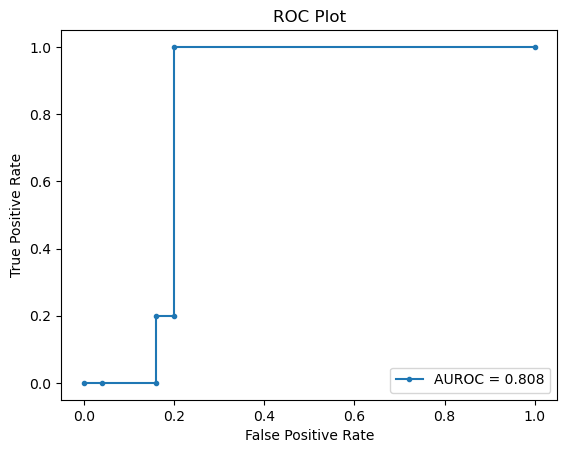

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, result_lst)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, result_lst))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [46]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.04 0.16 0.16 0.2  0.2  1.  ]
The tpr is:  [0.  0.  0.  0.2 0.2 1.  1. ]
The thresholds are:  [3.08359855 2.08359855 1.90652175 1.9015314  1.89062082 1.77090926
 1.25796291]


Now, let's try to compute the AUC score with the probability score rather than directly the reconstruction error, which is stored in the "result_lst" variable

In [47]:
print(result_lst)

[1.6261002676827567, 1.4932659694126673, 1.370353789556594, 1.3755158923921131, 1.342782701764788, 1.3126402355375744, 1.4100286392938524, 1.4661696297781808, 1.7527961730957031, 1.5624157133556547, 1.7217132931663877, 1.6457388741629464, 1.747560046968006, 1.565327417282831, 1.4295565287272136, 1.6891846429734003, 1.3889837719145275, 1.257962908063616, 1.409334273565383, 1.9065217517671131, 1.8906208219982328, 1.9725854056222099, 2.0835985456194197, 2.061769031343006, 1.7671314421154203, 1.851381574358259, 1.8297184535435267, 1.7759858994256883, 1.7709092639741444, 1.9015314011346727]


In [48]:
na_avg_rcn_error + na_stdev_rcn_error

1.5762185752806954

In [49]:
preds_probs = np.array(map_error2prob_list(result_lst))
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

The prediction probabilities list for the non-anomaly images is: 
[54.04855025 43.26731358 33.2913863  33.71035831 31.05363275 28.60717829
 36.51151808 41.06809204 64.33157623 48.87971764 61.80879492 55.64247943
 63.90659627 49.11604041 38.09646112 59.16867049 34.80345247 24.16939968
 36.45516124 76.80841291 75.51784497 82.17034049 91.18050541 89.40875547
 65.49507037 72.33306799 70.57482305 66.21372512 65.80168991 76.40338084]


With the above result the AUC score is expected to be lower than the previous one.

AUC =  0.808


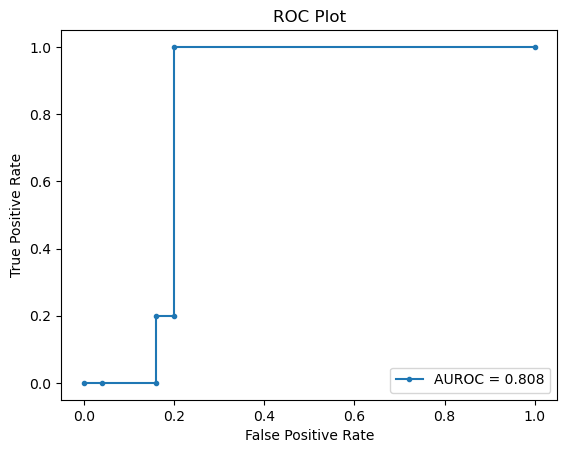

In [50]:
print('AUC = ', metrics.roc_auc_score(y_true, preds_probs))
fpr, tpr, thresholds = metrics.roc_curve(y_true, preds_probs)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, preds_probs))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()